# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." For this year's week 2 machine learning challenge, BWSI has revived a past PhysioNet challenge based on sleep classification.

This year's challenge focuses on the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [ ]:
### Import libraries ###

import matplotlib.pyplot as plt
import matplotlib

#set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
import pickle

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class descriptions:**

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/sleepStagesTable.svg?raw=true">

***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run the below cell block to get the challenge data.

In [ ]:
# Clone repo and move into data directory (only run this once)
!git clone https://github.com/Medlytics2022/Week2
os.chdir('./Week2/Datasets/ChallengeProject/')

fatal: destination path 'Week2' already exists and is not an empty directory.


## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals. 
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data. 
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the training data.

We encourage you to print each of these variables to see what they look like.

In [ ]:
### Run once to import data ###

def get_file_locs():
    '''
    find all files in 'training' and 'test' directories and put their names 
    under 'training' and 'test' keys in the file_dict dictionary
    '''

    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)
    
    return file_dict

def get_sample_data(data_type, id_number):
    '''
    get signal data, label, and filename associated with given data type and index num

    parameters:

     data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

     id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

     sample_data -- dataframe with 1 row and 2 columns-- column "Signal" contains a series object 
                    and column "Label" contains numeric label for that sample
    '''
    file = './' + data_type + '/' + str(id_number) + '.xz'

    #sample_data is a dataframe with 1 row and 2 columns--
    #"Signal" (contains a series object) and "Label" (contains numeric label)
    sample_data = pd.read_pickle('./' + file)

    return sample_data, file.split('/')[2]

file_dict = get_file_locs()
print(f"{len(file_dict['training'])} training samples found, {len(file_dict['test'])} test samples found")

4000 training samples found, 1000 test samples found


In [ ]:
data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample_data, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample_data['Signal']), dtype=np.float64).reshape(12000, 7)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=np.float64)
  ID_train.append(ID)
  if(i%500==0):
    print('Loading training sample ' + str(i))

Loading training sample 0
Loading training sample 500
Loading training sample 1000
Loading training sample 1500
Loading training sample 2000
Loading training sample 2500
Loading training sample 3000
Loading training sample 3500


In [ ]:
data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample_data, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample_data['Signal']), dtype=np.float64).reshape(12000, 7)
  ID_test.append(ID)
  if(i%500==0):
    print('Loading test sample ' + str(i))

Loading test sample 0
Loading test sample 500


## Data Visualization

Run the cell below to visualize the raw data for a single 60s sample for all 7 signals. We strongly urge you to visualize a few different samples to get a feel for how the data looks and how much each signal can vary in amplitude and frequency from sample to sample. You can change which sample is being visualized by changing the arguments to the graph_signals call.

Training 1083 (NREM1)


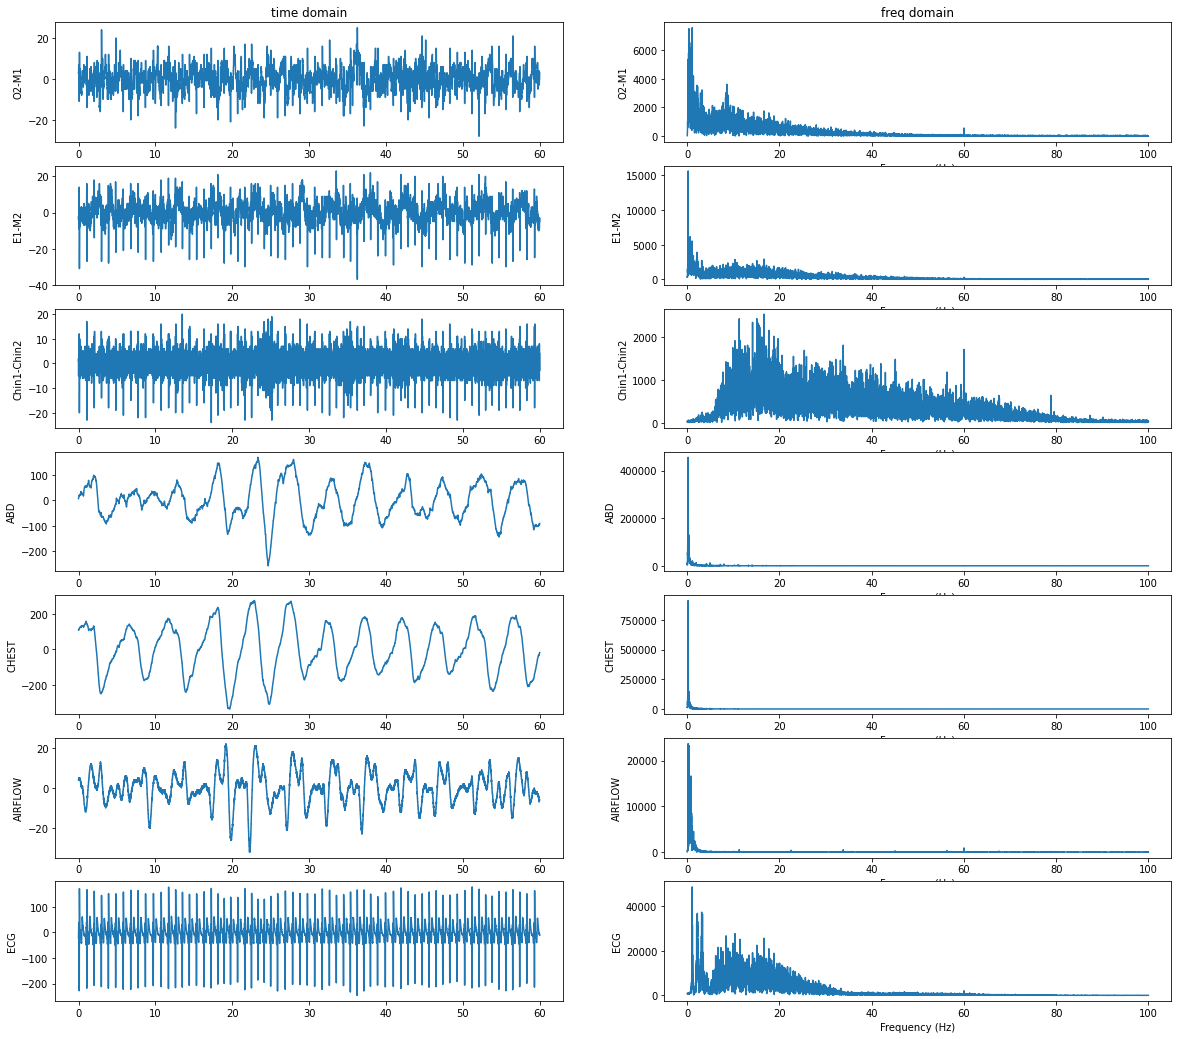

In [ ]:
### Define some useful functions to retrieve and plot data from individual samples ###

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

def graph_signals(data_type = 'training', id_number = None):
    '''
    Create a graph of multiple signals, with rows representing signal class, and
    columns representing signal domain (i.e. time or frequency) 
    
    inputs:
    
      parameters:

      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    '''

    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'

    if id_number is None:
      if data_type == 'training':
        id_number = random.randint(0,3999)
      else:
        id_number = random.randint(0,999)

    #set time_signal_y based on 'test' or 'training' input
    if data_type == 'training':
        #time_signal_y = data_train_orig[id_number,:,:]
        time_signal_y = data_train[id_number,:,:]
    else:
        #time_signal_y = data_test_orig[id_number,:,:]
        time_signal_y = data_test[id_number,:,:]

    #Get signal values in time domain from either data_train_orig, or data_test_orig
    time_signal_x = np.arange(0, 60, step = 1/200) #this time axis doesn't change

    #Use time-domain signals to get frequency domain signals
    num_datapoints = time_signal_x.shape[0]
    freq_signal_x = np.arange(num_datapoints//2 + 1)/60
    freq_signal_y = np.ndarray(shape = (num_datapoints//2 + 1, 7))
    freq_signal_y = np.abs(np.fft.rfft(time_signal_y, axis = 0))

    plt.figure(figsize = (20, 18))
    title_list = ['time domain', 'freq domain']
    for signal_index in range(7): #7 classes of signal (O2-M1, E2-M2, etc.)
        for signal_domain_index in range(2): #2 types of signal (time and freq domain)
            plt.subplot(7, 2, 2*signal_index + signal_domain_index + 1)
            if signal_index==0:
                plt.title(title_list[signal_domain_index])
            if signal_domain_index == 0: #plot time domain signal
                plt.plot(time_signal_x, time_signal_y[:,signal_index])
            if signal_domain_index == 1: #plot freq domain signal
                plt.plot(freq_signal_x, freq_signal_y[:,signal_index])
            plt.ylabel(sig_dict[signal_index])
        plt.xlabel(sig_type_dict[signal_domain_index])
    plt.show()

# We can now use the above functions to retrieve data for a single sample 
# (in the test or training set) and then plot it

# change these 2 lines to plot different samples (note that test set only has 1000 samples)
data_type = 'training'
id_number = random.randint(0, 3999)

#print signal ID and the sample label (if known)
if data_type == 'training': 
    print(data_type.title(), str(id_number), '(' + stage_dict[id_number//800] + ')')
else: 
    print(data_type.title(), str(id_number), '(Unknown)')

#plot data from this sample
graph_signals(data_type = data_type, id_number = id_number)

## Example Classifier

Below is an example of a mediocre classifier for this dataset. It is a simple neural network that uses the spectral flatness of all signal classes its input features--that is, it has 7 input features.

While the example classifier makes use of a neural network, we encourage you to utilize any ML algorithm that you feel would be appropriate.

In [ ]:
### Define functions that calculate the features of a single sample ###
import statistics
import scipy.stats.mstats as mstats

#I'm going to use spectral_flatness of the fft as a feature that could be used

def spectral_flatness(fft, zero_thresh = None): 
  N = len(fft) 
  magnitude = abs(fft[:N//2])* 2 / N 

  if(zero_thresh is not None):
      magnitude[magnitude < zero_thresh] = zero_thresh

  if(any(magnitude<zero_thresh)):
    raise ValueError("THis shouldn't happen")

  sf = mstats.gmean(magnitude) / np.mean(magnitude) 
  
  return sf


# specValues = []
def spectral_centroid(ft, f_s):
    
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    
    freqs = freqs[0:num_samples//2]
    ffff = 2/num_samples
    if num_samples == 0:
        print("ERROR")
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)
    # spec_centroid = np.sum(np.multiply(magnitude, freqs))/np.sum(magnitude)
    spec_centroid = np.sum(magnitude*freqs)/np.sum(magnitude)

    if np.isnan(spec_centroid):
        # print("FOUND NAN")
        spec_centroid = 0
    
    # specValues.append(spec_centroid)

    return spec_centroid

def spectral_rolloff(ft, f_s):
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    # Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[1:num_samples//2]
    magnitude = np.abs(ft[1:num_samples//2]) * (2/num_samples)

    # Compute the sum of *all* the fourier transform magnitudes
    whole_sum = np.sum(magnitude)

    # Initialize a variable to hold the cumulative sum of the magnitudes of the
    # fourier transform as we loop over it.
    cumulative_sum = 0.0


    # Loop over each element in the fourier transform
    for k, ft_mag in enumerate(magnitude):
       #Add the current magnitude of the cumulative sum
        cumulative_sum += magnitude[k]     

         # Check if the cumulative sum is currently greater than 85% of the
         # whole sum, and return the frequency at which this inequality first
        # becomes true.
        if cumulative_sum >= 0.85*whole_sum:
            return freqs[k]

def max_freq(ft, f_s):
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    freqs = freqs[1:num_samples//2]
    mag = np.abs(ft[1:num_samples//2]) * (2/num_samples)

    max_ind = np.argmax(mag)
    max_frequency = freqs[max_ind]

    return max_frequency

def spectral_bandwith(ft, f_s):
    num_samples = len(ft)
    freqs = np.linspace(0, f_s, num_samples)

    # Grab the magnitude of the relevant part of the fourier transform values
    freqs = freqs[0:num_samples//2]
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)

    p= 2

    bandwith = 1 #(np.sum(magnitude*(freqs-spectral_centroid(ft,f_s))**p))**(1/p)
    return bandwith

def spectral_flux(ft):
    num_samples = len(ft) 
    magnitude = np.abs(ft[0:num_samples//2]) * (2/num_samples)
    #flux = 0
    p = 2
    sf = np.sum(np.abs(np.diff(magnitude))**p)**(1/p)
    # for k, ft_mag in enumerate(magnitude): 
    #     if k > 0: 
    #         flux += (ft_mag - magnitude[k-1])**2
    return sf

def get_features_for_single_sample(data_type = 'training', id_number = None):
    '''
    Calculate some number feature values for a single sample

    parameters:

      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

      feature_vector -- 1d array containing all feature values for this sample
    '''

    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'

    if id_number is None:
        id_number=random.randint(0,999)

    if data_type == 'training':
        #time_signal_y = data_train_orig[id_number,:,:]
        time_signal_y = data_train[id_number,:,:]
    else:
        #time_signal_y = data_test_orig[id_number,:,:]
        time_signal_y = data_test[id_number,:,:]
  
    #---Populate feature vector ---
    #(Example uses spectral flatness, but you can populate feature_vector with 
    # anything that seems useful)

    #get an fft for all signals in this sample
    fft_arr = np.fft.rfft(time_signal_y, axis = 0)
    
    #Initialize feature vector to zeros of right size
    feature_vector = np.zeros((time_signal_y.shape[1]*5,1))

    #Enumerate over all classes of signal, calculate spectral flatness for each and append value to feature_vector
    for ind in range(fft_arr.shape[1]): #for every class of signal
        feature_vector[ind*5] = spectral_flatness(fft_arr[:,ind], zero_thresh = 10**-10) #calculate spectral flatness and add it to a feature vector 
        feature_vector[ind*5+1] = spectral_centroid(fft_arr[:,ind], 200)
        feature_vector[ind*5+2] = max_freq(fft_arr[:,ind], 200)    
        feature_vector[ind*5+3] = spectral_flux(fft_arr[:,ind]) # originally was [ind*5+4]
        feature_vector[ind*5+4] = spectral_rolloff(fft_arr[:,ind], 200)
    # feature_vector = np.delete(feature_vector, 5)
    # for ind in range(fft_arr.shape[1]): #for every class of signal
    #     feature_vector[ind] = spectral_flatness(fft_arr[:,ind], zero_thresh = 10**-10)

    #---Finished populating feature vector---
    #(now feature_vector is populated with hand-engineered features for this sample)

    return feature_vector
    
def get_features(data_type, num_samples):
    specValues = []
    '''
    Retrieve features from num_samples samples in either test or training set, 
    return features for each sample and index of each sample
    
    inputs:
    
      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      num_samples -- For how many samples should features be calculated?
                  (should not exceed total samples in a given data_type)
  
    returns:

      features -- n x p array of feature values for all samples where rows 
                  correspond to samples and columns correspond to feature number

      order -- 1d array where index i contains the index of row i of the feature vector
               (only needed if shuffling takes place later)
    '''

    features, order = np.array([]), np.array([])
    for i in range(num_samples):
        single_sample_features = get_features_for_single_sample(data_type = data_type, id_number = i)
        features = np.hstack((features, single_sample_features)) if features.size else single_sample_features
        order = np.append(order, i).astype(np.float32)

    #ensure features are of type float32    
    features = features.astype(np.float32)

    return np.transpose(features), order


In [ ]:
### Run every time you modify your feature extraction ###

print('calculating features for training data...')
train_data, train_order = get_features('training', 4000)
# train_data = np.remove(train_data, )
# print(len(train_data))
# train_data = np.asarray(train_data)
# print(train_data)


print('calculating features for test data...')
test_data, test_order = get_features('test', 1000)

calculating features for training data...
<ipython-input-7-1e62533938a7>:35: RuntimeWarning: invalid value encountered in double_scalars
  spec_centroid = np.sum(magnitude*freqs)/np.sum(magnitude)
calculating features for test data...


## Visualize Entire Dataset's Features

In [ ]:
### Create label array for all training samples using categorical datatype ###

train_labels = np.ndarray(shape = (1, 4000))

# set labels to integers first
for i in range(4000):
    train_labels[0][i] = i//800 # This is a way to label each entry (since classes are in order)

# convert labels to onehot, ensure type is float32
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5)
train_labels = train_labels.astype(np.float32)

train_data.shape = (4000, 35) 
 train_labels.shape = (4000, 5)


train data:
 [[5.3745472e-01 2.4562183e+01 1.1333333e+00 ... 1.2266666e+01
  1.3505031e+02 4.9433334e+01]
 [4.1682139e-01 2.0037544e+01 1.4333333e+00 ... 9.2666664e+00
  1.5581383e+02 5.5966667e+01]
 [4.7034150e-01 2.3462313e+01 6.0000002e-01 ... 5.7666669e+00
  4.6266742e+02 5.1266666e+01]
 ...
 [4.3870151e-01 2.2371296e+01 4.3333334e-01 ... 8.1999998e+00
  2.8839227e+02 5.6166668e+01]
 [3.9602661e-01 2.0541609e+01 1.8333334e+00 ... 2.3000000e+00
  2.6747543e+02 5.5633335e+01]
 [4.2380518e-01 2.0479746e+01 6.0000002e-01 ... 1.8000000e+00
  3.2642972e+02 4.9566666e+01]]

train labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


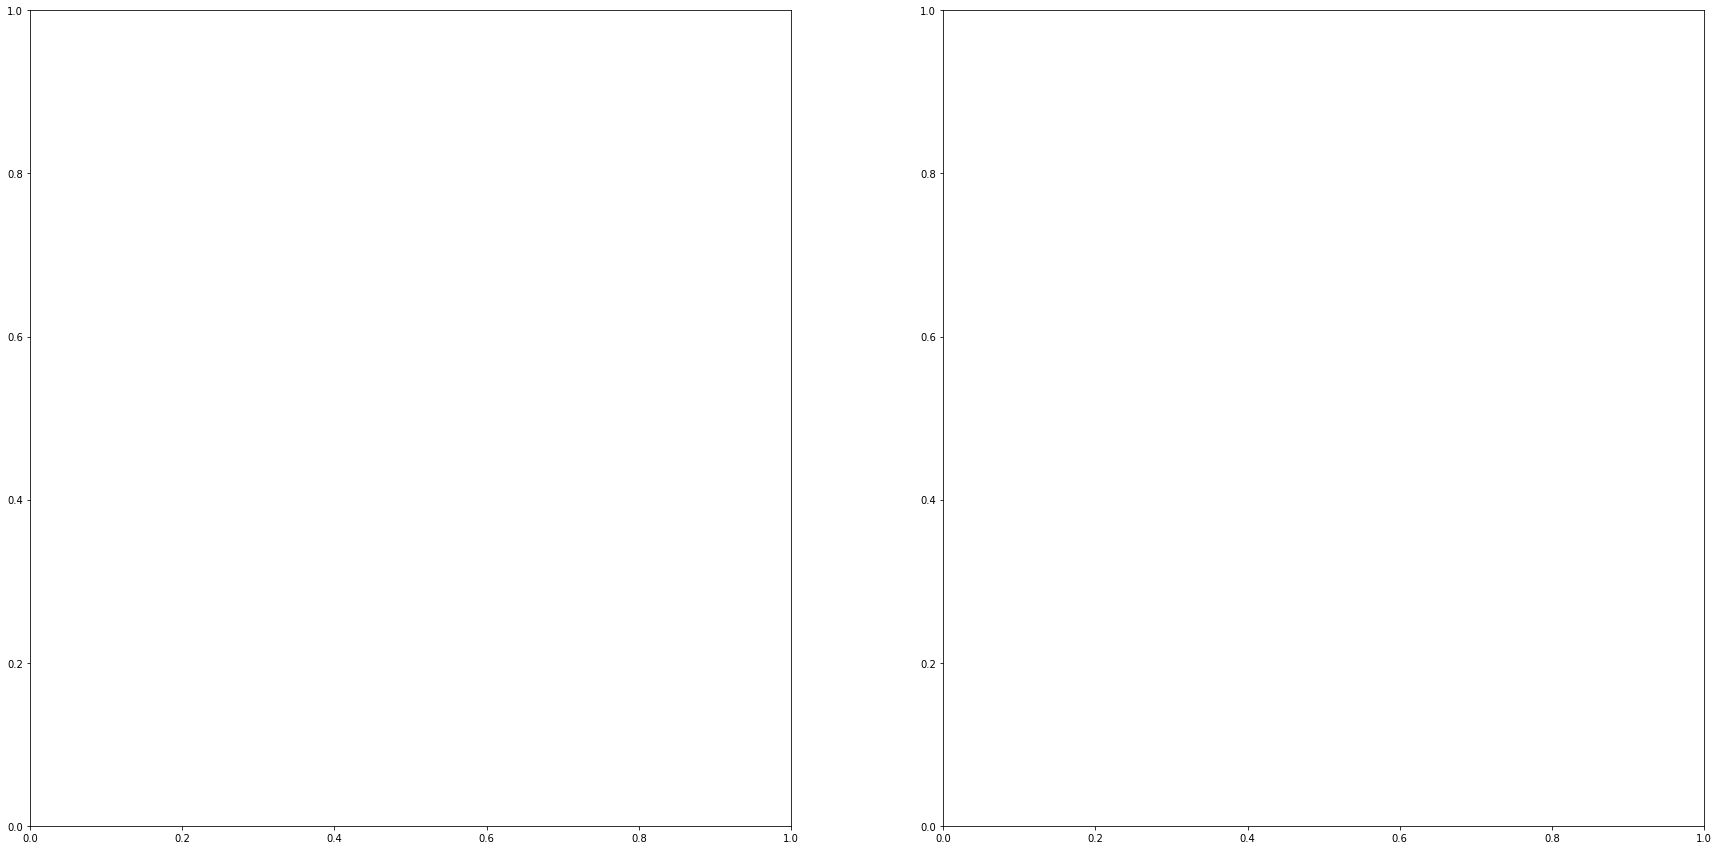

<Figure size 432x288 with 0 Axes>

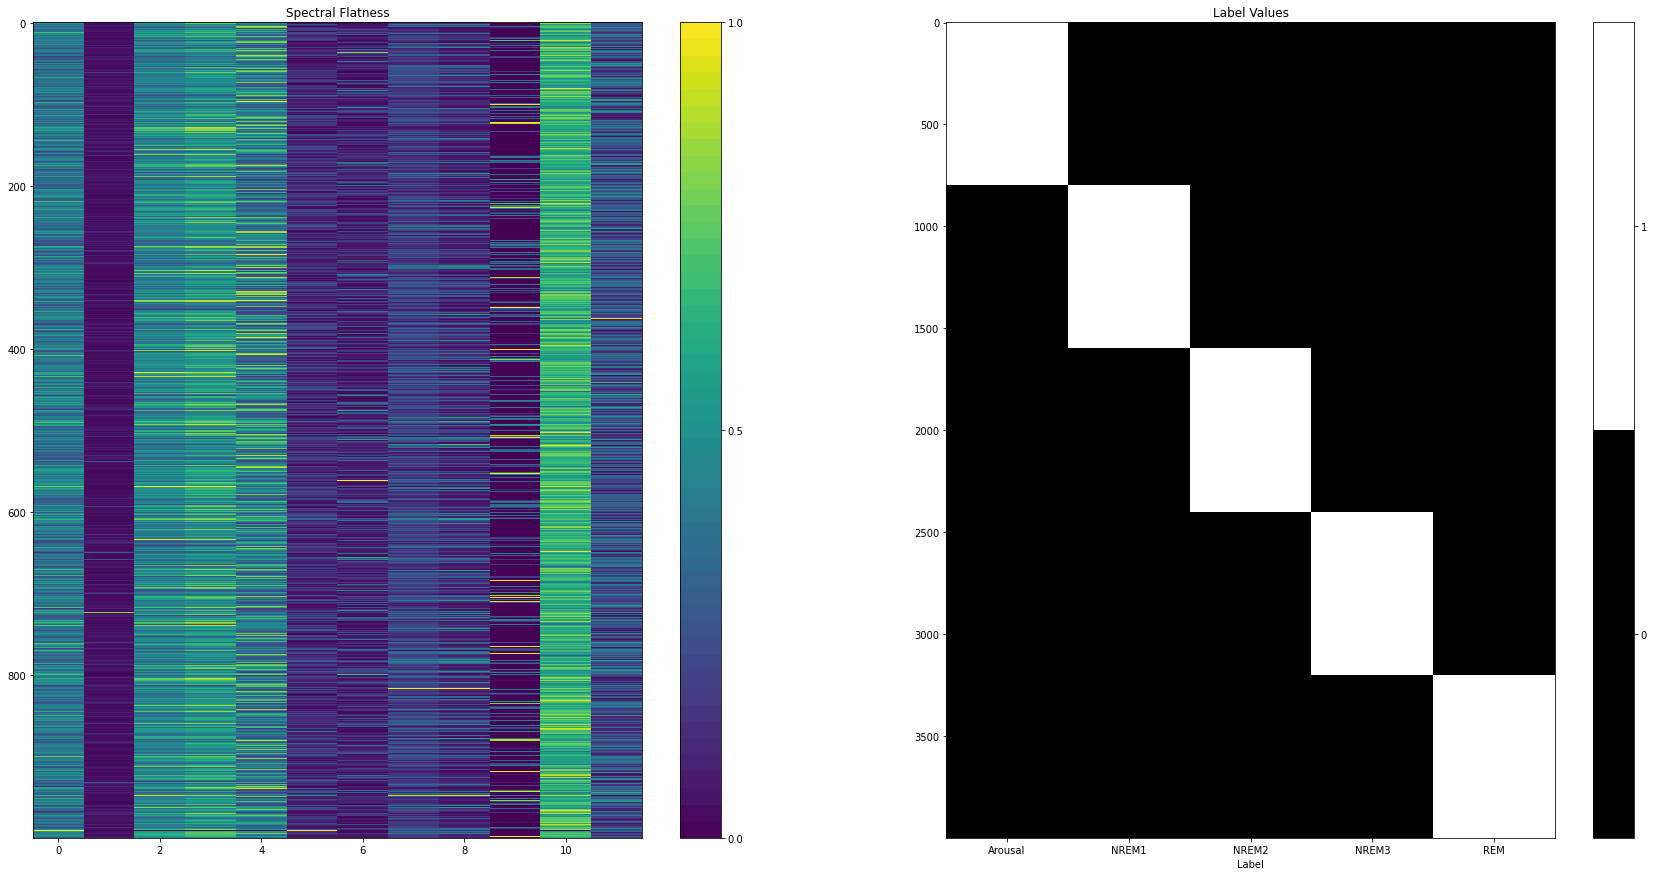

<Figure size 432x288 with 0 Axes>

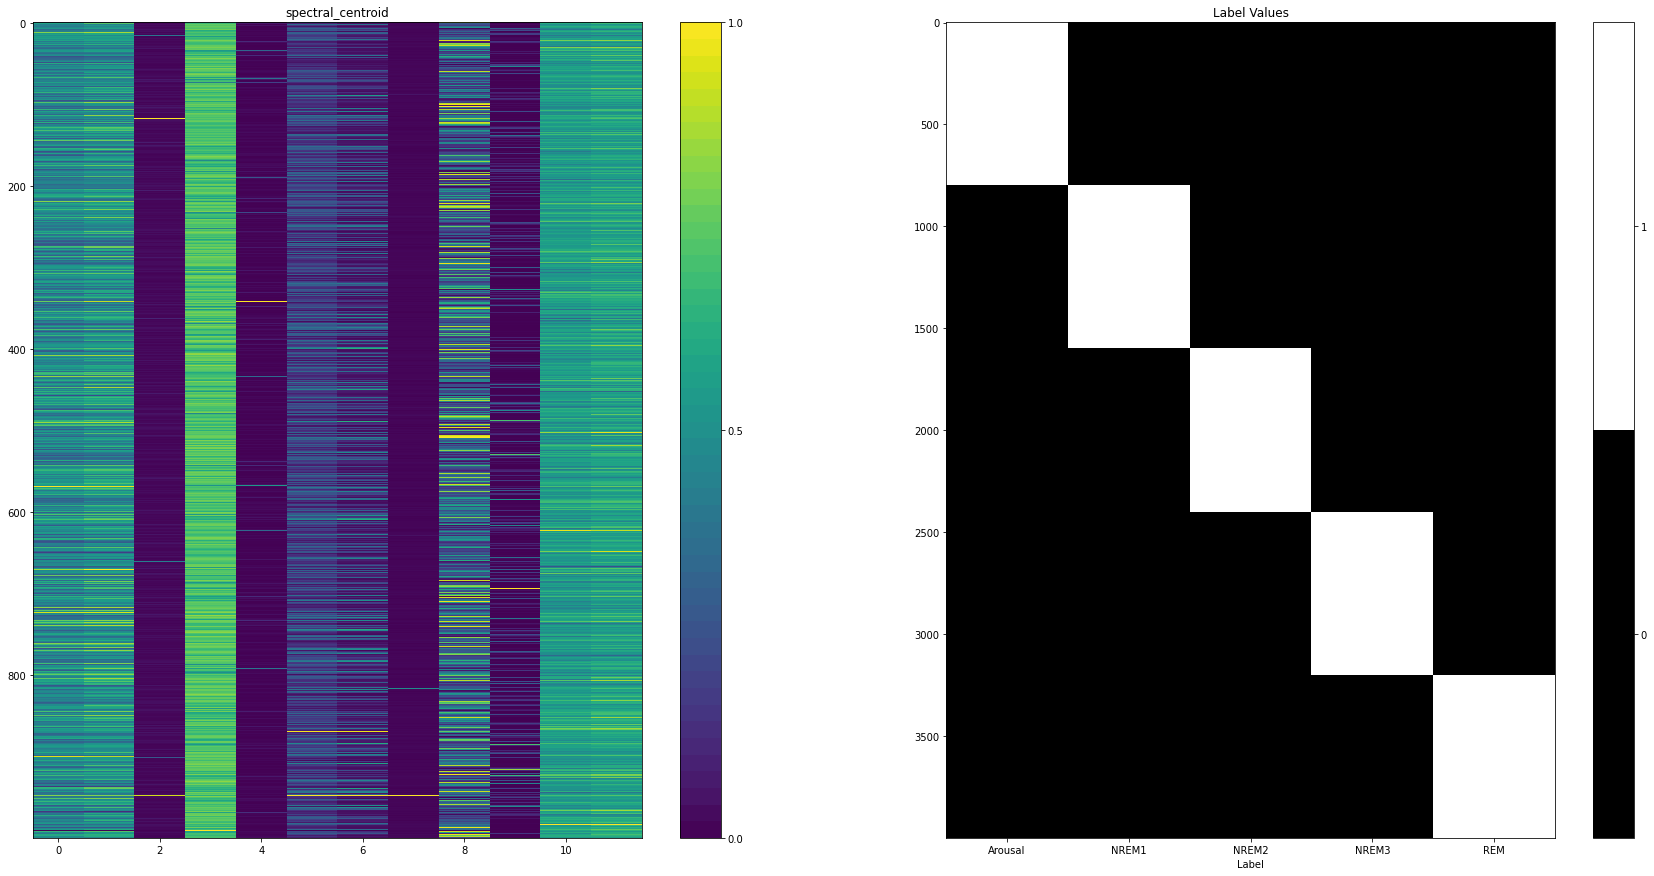

<Figure size 432x288 with 0 Axes>

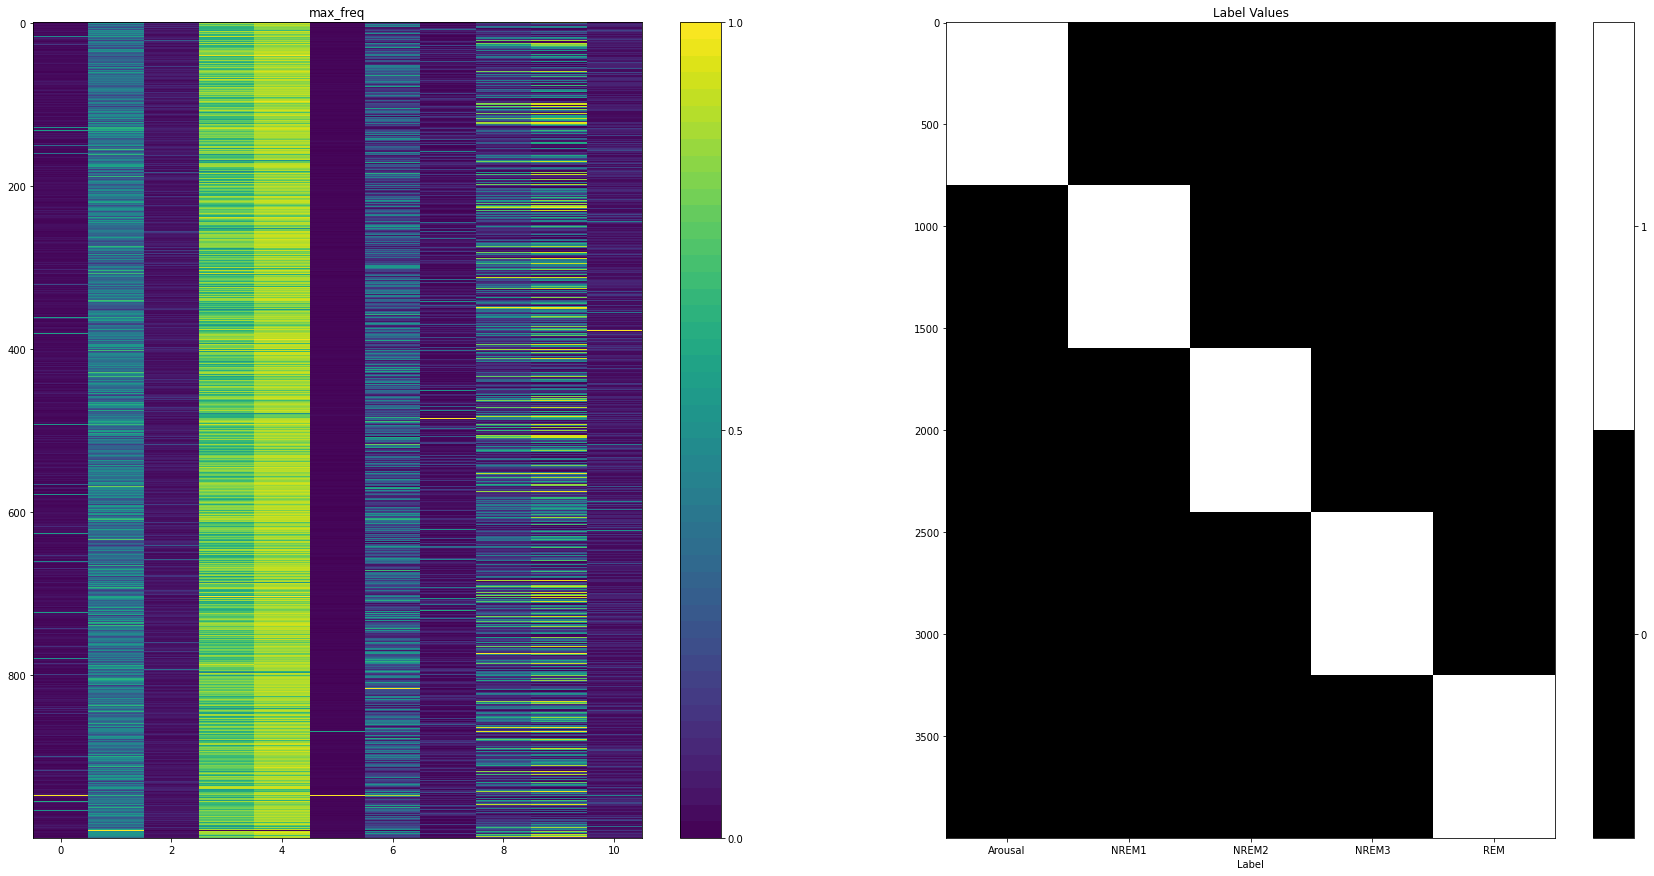

<Figure size 432x288 with 0 Axes>

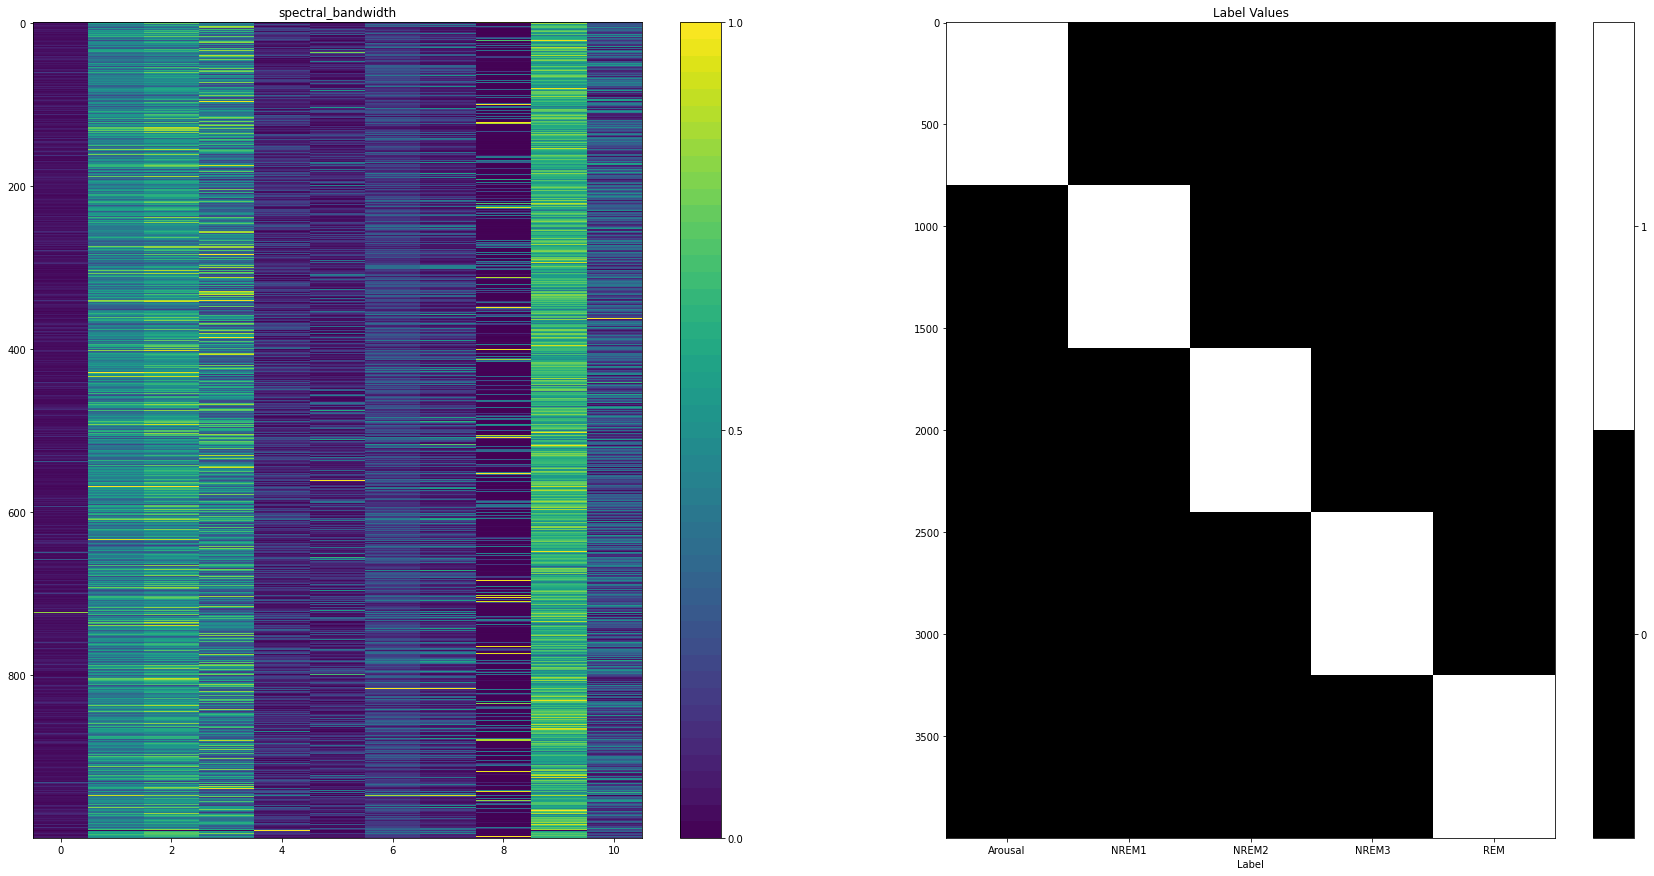

<Figure size 432x288 with 0 Axes>

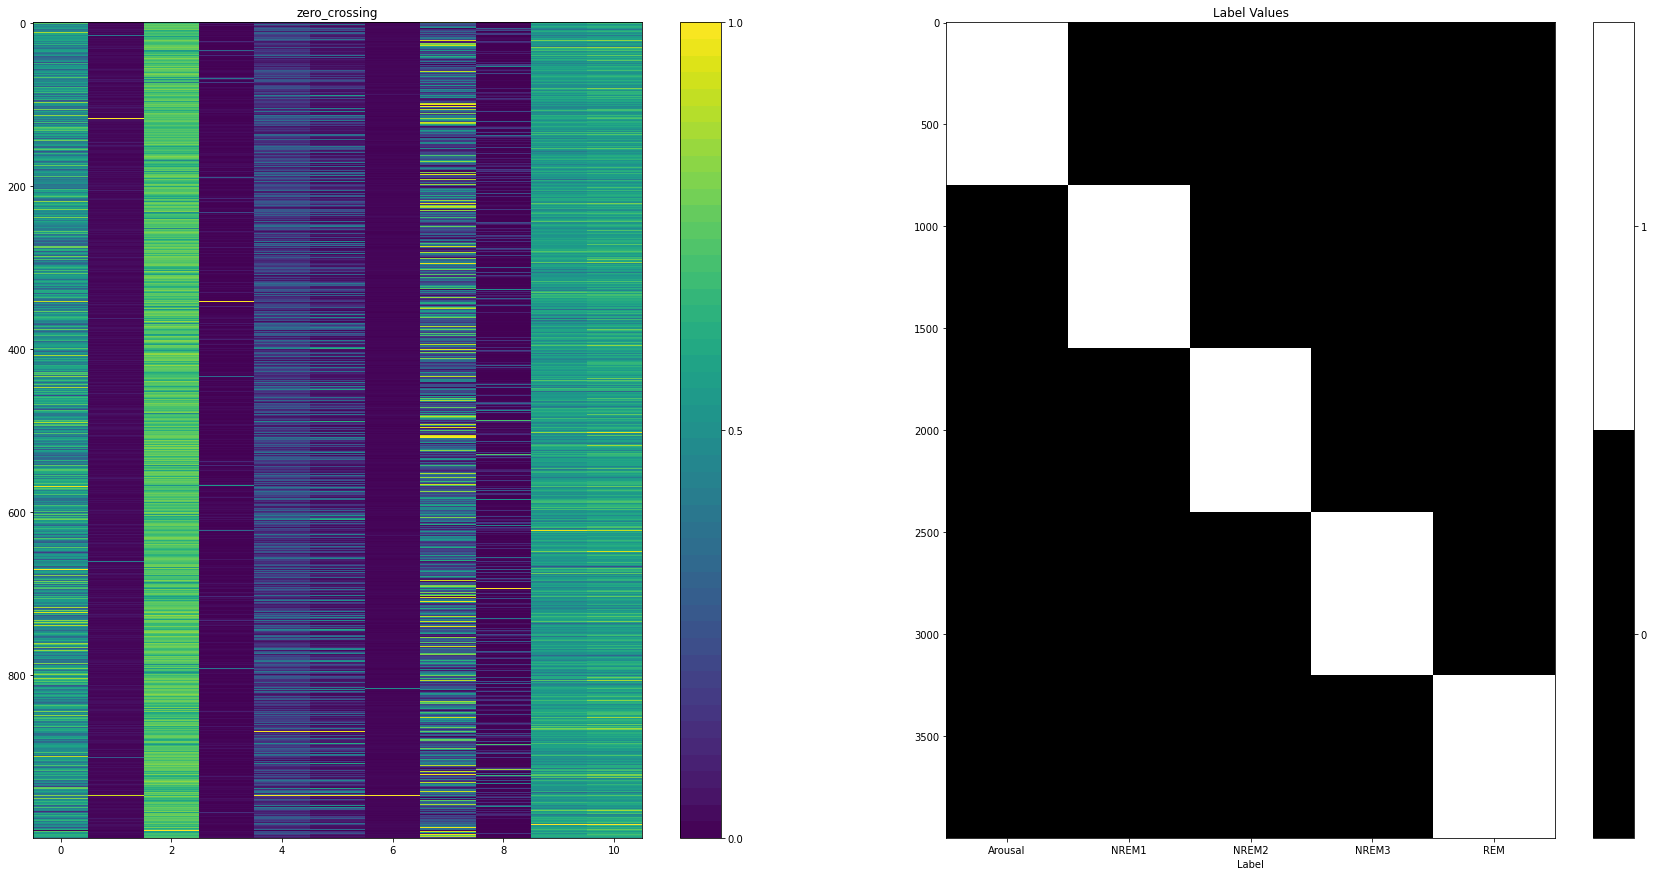

In [ ]:
### Run whenever you want to check or view your data and labels ###
print(f"train_data.shape = {train_data.shape} \n train_labels.shape = {train_labels.shape}\n\n")
print(f"train data:\n {train_data}\n\ntrain labels:\n {train_labels}")
#plot feature values and label values to show data clearly
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize= (30,15))

# Note: if your features are not scaled to the range 0->1 you might want to change vmin and vmax
names = ['Spectral Flatness', 'spectral_centroid', 'max_freq', 'spectral_bandwidth', 'zero_crossing']
# g = ax1.imshow(test_data[:,range(i, 35, 5)], aspect = 'auto', interpolation = 'None') #vmin = 0, vmax = 1.0)
#     ax1.set_title(names[i])
#     ax1.set_ylabel('Sample Number')
#     ax1.set_xlabel('Feature Number')
    # fig.colorbar(fea
for i in range(0, 5):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize= (30,15))

    data_to_plot = test_data[:,range(i, 35, 3)]
    # Normalization by column
    column_maxes = data_to_plot.max(axis=0)
    # print('column_maxes dim:',column_maxes.shape)
    data_to_plot = data_to_plot/column_maxes

    featureImg = ax1.imshow(data_to_plot, aspect = 'auto', interpolation = 'None') #vmin = 0, vmax = 1.0)
    ax1.set_title(names[i])
    # plt.title(names[i])
    # plt.set_ylabel('Sample Number')
    # plt.set_xlabel('Feature Number')
    fig.colorbar(featureImg, ax = ax1, boundaries = np.linspace(0.0, 1.0, 50), ticks = [0,0.5,1])
    # fig.show()
    from matplotlib.colors import ListedColormap
    bw_cmap = ListedColormap(np.array([[0,0,0,1],[1,1,1,1]])) # make a colormap manually
    labelImg = ax2.imshow(train_labels, aspect = 'auto', cmap = bw_cmap,interpolation = 'None', vmin = 0, vmax = 1.0)
    ax2.set_title('Label Values')
    ax2.set_xlabel('Label')
    ax2.set_xticks(range(len(stage_dict)))
    ax2.set_xticklabels([stage_dict[i] for i in range(len(stage_dict))])
    fig.colorbar(labelImg, ax = ax2, boundaries = np.linspace(-0.5, 1.5,3), ticks = [0, 1])
    fig.show()

In [ ]:
#### Run every time you modify your feature extraction ###
#
# This cell splits up the labeled data into 3 subsets (training data, validation
# data, and test data)
#
# This 3-way split is very common in training a supervised learning model. The purpose of
# each partition is as follows:
#
# 1) Training data is used to adjust model weights (so-called model parameters)
# 2) Validation data is used to gauge how well model generalizes (allowing user 
#    to compare between different trained models and/or non-trained model 
#    parameters (hyperparameters))
# 3) Test data is used to provide an indicator of real-world performance (it 
#    should not be used when deciding between models because this would result 
#    in overfitting!)
# train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))



train_data_shuffled, train_labels_shuffled = shuffle(train_data, train_labels, random_state = 25)

# train_data_shuffled = np.reshape(train_data_shuffled, (train_data_shuffled.shape[0], train_data_shuffled.shape[1], 1))

""" val_size (int) must be from 0-4000 """
val_size = 2000
mocktest_size = 500

val_data = train_data_shuffled[:val_size]
mocktest_data = train_data_shuffled[val_size:val_size + mocktest_size]
partial_train_data = train_data_shuffled[val_size + mocktest_size:]

val_labels = train_labels_shuffled[:val_size]
mocktest_labels = train_labels_shuffled[val_size:val_size + mocktest_size]
partial_train_labels = train_labels_shuffled[val_size + mocktest_size:]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.batch(40) #set batch size

In [ ]:
f = list(training_set)
arraynp = np.array(f)
print(np.shape(arraynp))

(38, 2)
<ipython-input-12-40240745e548>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arraynp = np.array(f)


In [ ]:
##LSTM 




#################




# ### Run every time you change set of parameters ###
# l_r = 0.0005
# d_r = 0.2
# p_s = 1
# model = tf.keras.Sequential()

# #model.add(tf.keras.layers.LSTM(128, activation=tf.nn.relu, ))
# """ Modify to your heart's and algorithm's content ^_^ """

# model.add(tf.keras.layers.Dense(196, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(196, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(196, activation=tf.nn.relu))
# #model.add(tf.keras.layers.MaxPool1D(pool_size=p_s))
# #model.add(tf.keras.layers.AveragePooling1D(pool_size=p_s))
# #model.add(tf.keras.layers.Flatten(data_format=))
# model.add(tf.keras.layers.Dropout(rate = d_r))
# #model.add(tf.keras.layers.Dense(96, activation=tf.nn.relu))
# #model.add(tf.keras.layers.Dense(48, activation=tf.nn.relu))


# model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax)) 
# #opt = tf.keras.optimizers.RMSprop(learning_rate=0.005)
# opt = tf.keras.optimizers.Adam(learning_rate=l_r)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.summary()

#train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
#val_data = np.reshape(val_data, (val_data.shape[0], val_data.shape[1], 1))

### Run every time you change set of parameters ###

model = tf.keras.Sequential()

""" Modify to your heart's and algorithm's content ^_^ """
# trial = train_data.reshape(4000,-1)
# print(trial,trial.shape)
#train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
# print(train_data,train_data.shape)
#model.add(tf.keras.layers.LSTM(196, activation=tf.nn.relu, return_sequences = True, input_shape=(train_data.shape[1],1)))

#WORKING LAYERS
model.add(tf.keras.layers.LSTM(units=30, input_shape=(train_data.shape[1],1), activation="relu"))
#model.add(tf.keras.layers.SimpleRNN(units=35, return_sequences = False, activation="relu"))
# model.add(tf.keras.layers.SI(units=128, input_shape=(train_data.shape[1],1), activation="relu"))
# model.add(tf.keras.layers.Dense(360, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(180, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(90, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(45, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(20, activation=tf.nn.relu))
##################

#model.add(tf.keras.layers.Dropout(0.002))

##LSTM
# print(train_data.shape[1])


model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax)) 
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                3840      
                                                                 
 dense_20 (Dense)            (None, 180)               5580      
                                                                 
 dense_21 (Dense)            (None, 90)                16290     
                                                                 
 dense_22 (Dense)            (None, 45)                4095      
                                                                 
 dense_23 (Dense)            (None, 20)                920       
                                                                 
 dense_24 (Dense)            (None, 5)                 105       
                                                                 
Total params: 30,830
Trainable params: 30,830
Non-trai

In [ ]:
print(train_data.shape[1])

35


In [ ]:
print(train_data.shape)

(4000, 35)


In [ ]:
### Run whenever you want to train and validate your model ###

"""
EPOCHS (int) the number of times the optimization algorithm passes
through the full dataset (calculating errors and derivatives) to update weights
(One pass through the data is called an "epoch")
"""

EPOCHS = 100
# signals = np.reshape(signals, (signals.shape[0], signals.shape[1], 1))
# labels = np.reshape(labels, (labels.shape[0], labels.shape[1], 1))
# test = np.zeros(40)
for epoch in range(EPOCHS):
    for signals, labels in training_set:
        #signals = np.reshape(signals, (signals.shape[0], signals.shape[1],1))
        # print(np.shape(signals))
        # print(np.shape(labels))
        #signals = signals.reshape(1, signals.shape[1], 1)
        # print(signals)
        # print(np.shape(labels))
        # print(np.shape(signals))
        # zeros = np.zeros(40)
        tr_loss, tr_accuracy = model.train_on_batch(signals, labels)
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
         'Validation Loss: %.2f\tValidation Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

63/63 [==============================] - 0s 3ms/step - loss: 1.6176 - accuracy: 0.2305
Epoch #1	 Training Loss: 1.67	Training Accuracy: 0.20	Validation Loss: 1.62	Validation Accuracy: 0.23
63/63 [==============================] - 0s 4ms/step - loss: 1.6095 - accuracy: 0.2185
Epoch #2	 Training Loss: 1.60	Training Accuracy: 0.25	Validation Loss: 1.61	Validation Accuracy: 0.22
63/63 [==============================] - 0s 4ms/step - loss: 1.6138 - accuracy: 0.2250
Epoch #3	 Training Loss: 1.63	Training Accuracy: 0.20	Validation Loss: 1.61	Validation Accuracy: 0.22
63/63 [==============================] - 0s 3ms/step - loss: 1.6089 - accuracy: 0.2210
Epoch #4	 Training Loss: 1.59	Training Accuracy: 0.15	Validation Loss: 1.61	Validation Accuracy: 0.22
63/63 [==============================] - 0s 4ms/step - loss: 1.6214 - accuracy: 0.2330
Epoch #5	 Training Loss: 1.59	Training Accuracy: 0.30	Validation Loss: 1.62	Validation Accuracy: 0.23
63/63 [==============================] - 0s 4ms/step - 

In [ ]:
#Check Performance on Test Set
val_loss, val_accuracy = model.evaluate(val_data, val_labels)

63/63 [==============================] - 0s 4ms/step - loss: 1.6490 - accuracy: 0.5415


In [ ]:
### Run once after you have finished training your model ###

test_pred = model.predict(test_data)
test_output = np.ndarray(shape = (1000, 6))

# """ Add column with file number """
for i in range(1000):
    test_output[i] = np.append(test_pred[i], test_order[i]) 
test_dataframe = pd.DataFrame(test_output)

""" Sort dataframe according to file number """
sorted_test_dataframe = test_dataframe.sort_values(by=[5])

""" Drop file number column """
processed_test_dataframe = sorted_test_dataframe.drop(sorted_test_dataframe.columns[5], axis=1)

print(test_dataframe.head(), '\n\n', sorted_test_dataframe.head(), '\n\n', processed_test_dataframe.head())

# In the file name, make sure to indicate your team number
# The file should show up in the file explorer to the left under Week2Project > Week2 > Datasets > ChallengeProject
# Download the pickle file and send it to medlytics22-staff@mit.edu
file = 'team#_test_preds.pkl'
os.chdir('./')
processed_test_dataframe.to_pickle(file)

test_dataframe = pd.DataFrame(test_output)
os.listdir('.')

32/32 [==============================] - 0s 4ms/step
          0         1         2         3         4    5
0  0.129614  0.014897  0.158829  0.696656  0.000003  0.0
1  0.598733  0.093059  0.306433  0.001612  0.000164  1.0
2  0.000846  0.008939  0.980829  0.000848  0.008537  2.0
3  0.038014  0.027407  0.910710  0.001075  0.022794  3.0
4  0.814139  0.013843  0.130482  0.037964  0.003573  4.0 

           0         1         2         3         4    5
0  0.129614  0.014897  0.158829  0.696656  0.000003  0.0
1  0.598733  0.093059  0.306433  0.001612  0.000164  1.0
2  0.000846  0.008939  0.980829  0.000848  0.008537  2.0
3  0.038014  0.027407  0.910710  0.001075  0.022794  3.0
4  0.814139  0.013843  0.130482  0.037964  0.003573  4.0 

           0         1         2         3         4
0  0.129614  0.014897  0.158829  0.696656  0.000003
1  0.598733  0.093059  0.306433  0.001612  0.000164
2  0.000846  0.008939  0.980829  0.000848  0.008537
3  0.038014  0.027407  0.910710  0.001075  0.0227

['training', 'test', 'team#_test_preds.pkl']

## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .pkl file using dataframe.to_pickle(). The file should show up in the file explorer to the right under Week2Project > Week2 > Datasets > ChallengeProject. Download the pickle file and send it to medlytics22-staff@mit.edu.

Example code of the prediction format and export is presented in the cell block above. 

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity. There will be a "winning" group for each of these categories.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/MultiClassRocCurve_exampleClassifier.png?raw=true" width="600" height="500">

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.727
- MCC: 0.163
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [ ]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

16/16 [==============================] - 0s 4ms/step


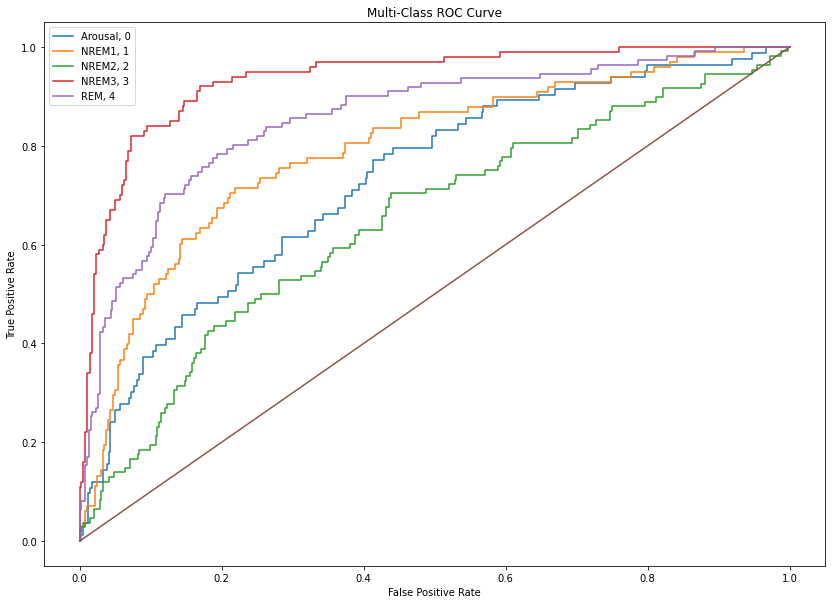

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [ ]:
print(roc_auc_agg, mcc)

0.8058510000000001 0.27832250364692507


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=19ac006e-49a7-4dc3-aeba-5d8f56912798' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>